# Анализ пользователей мобильного приложения по продаже продуктов питания

**Цель:**  
- Изучить воронку продаж. Узнать сколько пользователей доходят до покупки.
- Исследовать результат А/А/В - теста (изменение шрифта).  


**Шаги:**

1. Подготовка данных.  
2. Изучение и проверка данных.  
3. Анализ воронки событий.  
4. Анализ результатов эксперимента.  
5. Вывод.  


**Данные:**  
Путь к файлу: /datasets/logs_exp.csv.  
Каждая запись в логе — это действие пользователя, или событие.   
•	EventName — название события;  
•	DeviceIDHash — уникальный идентификатор пользователя;  
•	EventTimestamp — время события;   
•	ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.


## Предообработка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import numpy as np
import datetime as dt
import math as mth

from scipy import stats as st
from datetime import datetime, timedelta
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go
import re 
import plotly.express as px
init_notebook_mode(connected=True)

In [2]:
# код для отображения таблицы без усечений
pd.options.display.max_columns = 200
pd.options.display.max_colwidth = 250

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
data = pd.read_csv('/datasets/logs_exp.csv', sep='\s')
data

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [5]:
# переименуем колонки
data = data.rename(columns = {'EventName':'event_name', 'DeviceIDHash':'id', 'EventTimestamp':'date_time', 'ExpId':'exp_id'})
data

,event_name,id,date_time,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [6]:
# изменим тип данных
data['date_time'] = pd.to_datetime(data['date_time'], unit='s')
data

,event_name,id,date_time,exp_id
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246


In [7]:
# добавим колонку с датой
data['date'] = data['date_time'].dt.floor('1D')
data    

,event_name,id,date_time,exp_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


In [8]:
# выведим уникальные значения шагов
data['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [9]:
# уникальные значения групп
data['exp_id'].unique()

array([246, 248, 247])

In [10]:
# выведим информацию о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244126 non-null  object        
 1   id          244126 non-null  int64         
 2   date_time   244126 non-null  datetime64[ns]
 3   exp_id      244126 non-null  int64         
 4   date        244126 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


In [11]:
# проверим на дубликаты
data.duplicated().sum()

413

In [12]:
# удалим дубликаты
data = data.drop_duplicates()
data.duplicated().sum()

0

В предобработке мы изменили тип данных, добавили стобец с датой, проверили на пропуски и дубликаты, удалили дубликаты. Посмотрели уникальные значения.

## Проверка данных

In [13]:
# посмотрим шаги по убыванию
data['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

In [14]:
#посмотрим сколько всего действий было совершено
len(data['event_name'])

243713

In [15]:
# посмотрим сколько пользователей сколькой действий совершали
data['id'].value_counts()

6304868067479728361    2307
197027893265565660     1998
4623191541214045580    1768
6932517045703054087    1439
1754140665440434215    1221
                       ... 
395376432319166724        1
404128138074395619        1
6936517579657223951       1
5138854326043201424       1
3954096321632083010       1
Name: id, Length: 7551, dtype: int64

In [16]:
# посчитаем среднее количество действий на пользователя
data.groupby('id')['event_name'].count().mean()

32.27559263673685

In [17]:
# проверим минимальную и максимальную дату исследования
print(data['date_time'].min())
print(data['date_time'].max())

2019-07-25 04:43:36
2019-08-07 21:15:17


Text(0, 0.5, 'Кол-во действий')

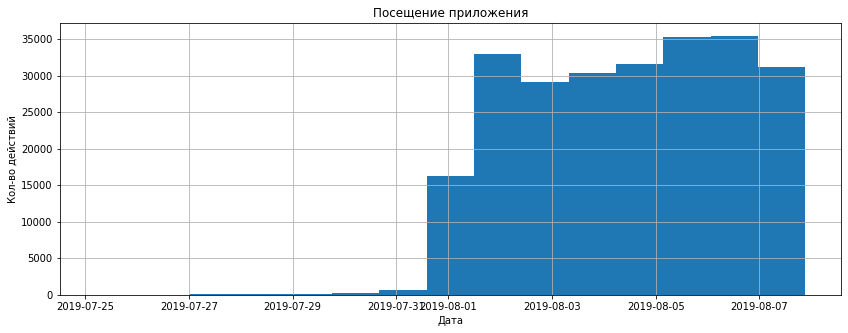

In [18]:
# построим гистограмму по дате
plt.figure(figsize=(14,5))
data['date_time'].hist(bins=15)
plt.title('Посещение приложения')
plt.xlabel('Дата')
plt.ylabel('Кол-во действий')



На гистограмме мы можем видеть, что всплеск активности начался с 01.08.19, поэтому то что было до этой даты исключим.

In [19]:
# сделаем срез данных
new_data = data.loc[data['date'] >= '2019-08-01']
new_data

,event_name,id,date_time,exp_id,date
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


In [20]:
# выведим информацию о новом столбце
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240887 entries, 2828 to 244125
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  240887 non-null  object        
 1   id          240887 non-null  int64         
 2   date_time   240887 non-null  datetime64[ns]
 3   exp_id      240887 non-null  int64         
 4   date        240887 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 11.0+ MB


In [21]:
# проверим сколько событий и пользователей мы отфильровали в долях
print('Доля отфильтрованных событий:', 1 - len(new_data)/len(data))

print('Доля отфильтрованных уникальных пользователей :', 1- new_data['id'].nunique()/data['id'].nunique())

Доля отфильтрованных событий: 0.01159560630741896
Доля отфильтрованных уникальных пользователей : 0.0022513574361011646


In [22]:
# проверим сколько пользователей в каждой группе теста
new_data['exp_id'].value_counts()

248    84563
246    79302
247    77022
Name: exp_id, dtype: int64

**Вывод:**
При проверке данныхвыяснили, что:  
- пользователь проходит 5 шагов  
- всего действий было совершено 243713   
- уникальных пользователей 7551  
- среднее количество действий на пользователя 32
- эксперимент проводился с 25.07-07.08, но не все данные во время подгрузились и поэтому в анализе мы берем только с 01.08-07.08
- доля отфильтрованных событий составила всего 1: 
- в каждой группе близкое количество народу.

## Анализ воронки событий

In [23]:
new_data['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

In [24]:
# сгруппируем данные по шагам, посмотри сколько действий сделано в каждом шаге, сколько уникальных пользователей 
# и долю пользователей в каждом шаге
event_group = new_data.groupby('event_name').agg({'event_name':'count', 'id':'nunique'}
                                                ).sort_values(by='id', ascending=False)
event_group.columns = ['n_events', 'users']
event_group = event_group.reset_index()
event_group['users_part_1event'] = (event_group['users'] / new_data['id'].nunique() * 100).round(1) 
event_group

,event_name,n_events,users,users_part_1event
0,MainScreenAppear,117328,7419,98.5
1,OffersScreenAppear,46333,4593,61.0
2,CartScreenAppear,42303,3734,49.6
3,PaymentScreenSuccessful,33918,3539,47.0
4,Tutorial,1005,840,11.1


События происходят в следующем порядке:

MainScreenAppear - главный экран  
Tutorial - обучение (по желанию)  
OffersScreenAppear - экран с товарами    
CartScreenAppear - экран с корзиной    
PaymentScreenSuccessful - Экран успешной оплаты заказа  
Этап Tutorial тут лишний, так как обязательным не является и не влияет на то, дойдет ли пользователь до финальной покупки или нет. Так же событий этого типа слишком мало для анализа по сравнению с другими. Уберем этат этап из нашего анализа.

In [25]:
fig = px.bar(event_group, x='event_name', y='users', title ='Посещение приложения по действиям')
fig.update_layout(xaxis_title="Название действия", yaxis_title="Кол-во уникальных пользователей")
fig.show()

In [26]:
# исключаем обучение из данных
new_data = new_data.query('event_name != "Tutorial"') 
event_group = event_group.query('event_name != "Tutorial"') 

In [27]:
# строим воронку 
from plotly import graph_objects as go

fig = go.Figure(
    go.Funnel(
        y=[
            'Главный экран',
            'Экран с товарами',
            'Перешли в корзину',
            'Оплатили',
        ],
        x=event_group['users'],
    textposition = "inside",
    textinfo = "value+percent previous+percent initial")
)
fig.update_layout(title_text='Воронка событий')
fig.show() 

Больше всего пользователей мы теряем после первого этапа это 38%, от первого этапа до этапа оплаты, доходит 48% пользователей, это хороший показатель. В основном те люди, которые добавили товар в корзину и перешли на страницу с корзиной, то есть 3 этап, оплачивают товар это 95%.

**Вывод:**
События происходят в следующем порядке:

MainScreenAppear - главный экран  
Tutorial - обучение (по желанию)  
OffersScreenAppear - экран с товарами    
CartScreenAppear - экран с корзиной    
PaymentScreenSuccessful - Экран успешной оплаты заказа  
Этап Tutorial тут лишний, так как обязательным не является и не влияет на то, дойдет ли пользователь до финальной покупки или нет. Так же событий этого типа слишком мало для анализа по сравнению с другими. поэтому дальнейший анализ проводим без него.

Больше всего пользователей мы теряем после первого этапа это 38%, от первого этапа до этапа оплаты, доходит 48% пользователей, это хороший показатель. В основном те люди, которые добавили товар в корзину и перешли на страницу с корзиной, то есть 3 этап, оплачивают товар это 95%.

## Анализ А/А/В-теста

In [28]:
# группируеи по группам и смотрим сколько всего уникальных пользователей, также соединям две группы и добавляем в данный столбец
test = new_data.groupby('exp_id')['id'].nunique()
test['246_247'] = test.loc[246] + test.loc[247]
test.reset_index()

,exp_id,id
0,246,2483
1,247,2512
2,248,2535
3,246_247,4995


In [29]:
# посмотрим сколько уникальных пользователей по событиям
a_a_test_1 = new_data.groupby('event_name')['id'].nunique()
a_a_test_1.to_frame()

,id
event_name,
CartScreenAppear,3734
MainScreenAppear,7419
OffersScreenAppear,4593
PaymentScreenSuccessful,3539


### A/A тест и подготовка к анализу теста

Н0: Между долями нет статистически значимой разницы   
Н1: Между долями есть статистически значимая разницы

In [30]:
# сгруппируем данные по пользователям и группам
group_sizes = new_data.groupby(['id', 'exp_id']).size().reset_index()
group_sizes.columns = ['visitor_id', 'group', 'count']
group_sizes = group_sizes.query('count > 1').sort_values(by='visitor_id')
group_sizes

,visitor_id,group,count
1,6909561520679493,247,5
2,6922444491712477,246,47
3,7435777799948366,248,6
4,7702139951469979,247,137
5,8486814028069281,248,10
...,...,...,...
7525,9217594193087726423,246,9
7526,9219463515465815368,248,17
7527,9220879493065341500,246,6
7528,9221926045299980007,246,7


In [31]:
# посмотрим какие есть дубликаты
duplucate = group_sizes[group_sizes['visitor_id'].duplicated()]
duplucate

,visitor_id,group,count


Никто не попал в несколько групп

In [32]:
# сделаем сводную таблицу  по событиям и группам
users_pivot = new_data.pivot_table(index='event_name',columns='exp_id', values='id', aggfunc='nunique').reset_index()
users_pivot = users_pivot.sort_values(by=246, ascending=False)
users_pivot

exp_id,event_name,246,247,248
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
0,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181


In [33]:
#добавим в таблицу сумму двух тестов А
users_pivot['246_247'] = users_pivot[246] + users_pivot[247]
# сумма пользователей
users_pivot['all'] = users_pivot['246_247'] + users_pivot[248]
# часть кажой группы от всех пользователей в каждом событии
users_pivot['part_246'] = (users_pivot[246] / test[246] * 100).round(1)
users_pivot['part_247'] = (users_pivot[247] / test[247] * 100).round(1)
users_pivot['part_248'] = (users_pivot[248] / test[248] * 100).round(1)
users_pivot['part_246_247'] = ((users_pivot[246] + users_pivot[247]) / \
                                  (test[246] + test[247]) * 100).round(1)
users_pivot['part_all'] = (users_pivot['all'] / test.sum() * 100).round(1)
users_pivot

exp_id,event_name,246,247,248,246_247,all,part_246,part_247,part_248,part_246_247,part_all
1,MainScreenAppear,2450,2476,2493,4926,7419,98.7,98.6,98.3,98.6,59.2
2,OffersScreenAppear,1542,1520,1531,3062,4593,62.1,60.5,60.4,61.3,36.7
0,CartScreenAppear,1266,1238,1230,2504,3734,51.0,49.3,48.5,50.1,29.8
3,PaymentScreenSuccessful,1200,1158,1181,2358,3539,48.3,46.1,46.6,47.2,28.3


### Функция для проведения теста

Так как у нас разные группы, то предлагаю провести z-тест. Так как при проверках у нас много будет разных тестов, предлагаю написать функцию по расчету статистической значимости для обращения

In [34]:
def z_test(group1, group2, alpha):
    for i in users_pivot.index:
        p1 = users_pivot[group1][i] / test[group1]
        # пропорция успехов во второй группе:
        p2 = users_pivot[group2][i] / test[group2]
        # пропорция успехов в комбинированном датасете:
        p_combined = ((users_pivot[group1][i] + users_pivot[group2][i]) / 
                      (test[group1] + test[group2]))
        # разница пропорций в датасетах
        difference = p1 - p2
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * 
                                        (1/test[group1] + 1/test[group2]))
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1) 
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('{} p-значение: {}'.format(users_pivot['event_name'][i], p_value))
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print('')

In [35]:
# смотрим z_test для АА тестирования и берем pval = 0.01 для точности АА-теста
z_test(246, 247, 0.01)

MainScreenAppear p-значение: 0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.22867643757335676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Критерии успешного A/A-теста:

- Количество пользователей в различных группах различается не более, чем на 1%;
- Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;
- Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;
- Попавший в одну из групп посетитель остаётся в этой группе до конца теста. 


По весм критериям A/A-тест можно считать успешным.

### Анализ A/B - теста

У нас 4 шага в воронке и 3 группы для сравнения. Поэтому на одних и тех же данных мы проведем тест 12-раз и нам необходимо сделать поправку Бонферони на множественную проверку гипотез. Для дальнеших проверок выберем критерий значимости стандартный 0.05.

Гипотезы:   
Н0: Между долями нет статистически значимой разницы  
Н1: Между долями есть статистически значимая разницы  

In [36]:
# функция с поправкой Бонферони
def z_test(group1, group2, alpha):
    for i in users_pivot.index:
        p1 = users_pivot[group1][i] / test[group1]
        # пропорция успехов во второй группе:
        p2 = users_pivot[group2][i] / test[group2]
        # пропорция успехов в комбинированном датасете:
        p_combined = ((users_pivot[group1][i] + users_pivot[group2][i]) / 
                      (test[group1] + test[group2]))
        # разница пропорций в датасетах
        difference = p1 - p2
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * 
                                        (1/test[group1] + 1/test[group2]))
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1) 
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('{} p-значение: {}'.format(users_pivot['event_name'][i], p_value))
        if (p_value < alpha/12):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print('')

In [37]:
# тест А1/В
z_test(246, 248, 0.05)

MainScreenAppear p-значение: 0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.08067367598823139
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.21693033984516674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [38]:
# тест А2/В
z_test(247, 248, 0.05)

MainScreenAppear p-значение: 0.5194964354051703
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.9333751305879443
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.5878284605111943
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.7275718682261119
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [39]:
# тест А/В
z_test("246_247", 248, 0.05)

MainScreenAppear p-значение: 0.3486684291093256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.44582745409482394
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.18683558686831558
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.6107918742187335
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод:** 
- Мы проверили данные на попадание в несколько групп и успешно провели АА-тестирование по всем критериям. 
- Значимой разницы между группами во всех тестах не выявлено, значит изменение шрифта никак не повлияло на конверсию, поэтому если дизайнеры уже изменили шрифт и считают что так будет лучше, то можно поменять. но на будущее не стоит тратить человеко-ресурсы, если это никак не повлият на наши текущие цели в бизнесе, лучше пересмотреть что-то другое, что б увеличить конверсию.

## Вывод

Во время анализа, мы: 
1. В предобработке мы изменили тип данных, добавили стобец с датой, проверили на пропуски и дубликаты, удалили дубликаты. Посмотрели уникальные значения.  

2. При проверке данныхвыяснили, что:  
- пользователь проходит 5 шагов  
- всего действий было совершено 243713   
- уникальных пользователей 7551  
- среднее количество действий на пользователя 32
- эксперимент проводился с 25.07-07.08, но не все данные во время подгрузились и поэтому в анализе мы берем только с 01.08-07.08
- доля отфильтрованных событий составила всего 1: 
- в каждой группе близкое количество народу.

3. События происходят в следующем порядке:

- MainScreenAppear - главный экран  
- Tutorial - обучение (по желанию)  
- OffersScreenAppear - экран с товарами    
- CartScreenAppear - экран с корзиной    
- PaymentScreenSuccessful - Экран успешной оплаты заказа  

Этап Tutorial тут лишний, так как обязательным не является и не влияет на то, дойдет ли пользователь до финальной покупки или нет. Так же событий этого типа слишком мало для анализа по сравнению с другими. поэтому дальнейший анализ проводим без него.

Больше всего пользователей мы теряем после первого этапа это 38%, от первого этапа до этапа оплаты, доходит 48% пользователей, это хороший показатель. В основном те люди, которые добавили товар в корзину и перешли на страницу с корзиной, то есть 3 этап, оплачивают товар это 95%. 

4. 
- Мы проверили данные на попадание в несколько групп и успешно провели АА-тестирование по всем критериям. 
- Значимой разницы между группами во всех тестах не выявлено, значит изменение шрифта никак не повлияло на конверсию, поэтому если дизайнеры уже изменили шрифт и считают что так будет лучше, то можно поменять. но на будущее не стоит тратить человеко-ресурсы, если это никак не повлият на наши текущие цели в бизнесе, лучше пересмотреть что-то другое, что б увеличить конверсию.